<a href="https://colab.research.google.com/github/F-Fawzi/Drug-Discovery-Machine-learning-and-data-analysis/blob/main/IFT6390_Projet_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IFT6390 - Projet Final
> **Christine Maher Assal**

> **Fatima Zahra Fawzi**


#0. Importation des données et librairies

In [ ]:
!pip install transformers
!pip install git+https://github.com/samsinai/FLEXS
!pip install warmup-scheduler
import flexs
import pandas
from flexs import baselines
import flexs.utils.sequence_utils as s_utils
training_data_pth = "https://raw.githubusercontent.com/SimonDufLab/IFT6390--H2023--Project/main/training_data.csv"
test_data_pth = "https://raw.githubusercontent.com/SimonDufLab/IFT6390--H2023--Project/main/test_data.csv"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/samsinai/FLEXS to /tmp/pip-req-build-dzwawx8s
  Running command git clone --filter=blob:none --quiet https://github.com/samsinai/FLEXS /tmp/pip-req-build-dzwawx8s
  Resolved https://github.com/samsinai/FLEXS to commit dd409167b5575b51967d325b4e48aef3577a505f
  Preparing metadata (setup.py) ... done
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#1. Modèle de substitution Multi-SWAG

In [ ]:
# Imports
import torch
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from torch import nn
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torch.distributions import Normal
from torch.optim.lr_scheduler import CosineAnnealingLR
from warmup_scheduler import GradualWarmupScheduler
import copy

In [ ]:
# Read data 
train_data = pd.read_csv(training_data_pth)
test_data = pd.read_csv(test_data_pth)

In [ ]:
# Encodage one hot sous forme d'un tableau à une dimension
def one_hot_encode_dna_df(sequence):
    seq_len = len(sequence)
    encoding = np.zeros((seq_len, 4))
    base_to_index = {'A': 0, 'C': 1, 'G': 2, 'T': 3}
    
    for i, base in enumerate(sequence):
        encoding[i, base_to_index[base]] = 1
    return encoding.flatten()

# Concatenate starting_seq and binding for training
train_data['seq_pair'] = train_data['starting_seq'] + train_data['binding']
test_data['seq_pair'] = test_data['starting_seq'] + test_data['binding']


train_data['one_hot'] = train_data['seq_pair'].apply(one_hot_encode_dna_df)
test_data['one_hot'] = test_data['seq_pair'].apply(one_hot_encode_dna_df)

input_data = np.vstack(train_data['one_hot'].values)
output_data = train_data['fitness'].values
X_train, X_val, y_train, y_val = train_test_split(input_data, output_data, test_size=0.2, random_state=42)

# Données d'entrées et de sorties
X_test = np.vstack(test_data['one_hot'].values)
y_test = test_data['fitness'].values

In [ ]:
# Initialisation des données d'entrée(X) et de sortie(y)
class DNADataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return torch.tensor(self.X[idx], dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)

# Création de train, validation et test DataLoaders
train_dataset = DNADataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = DNADataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

test_dataset = DNADataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=32)

In [ ]:
# Modèle de réseaux de neurones utilisé dans le modèle Multi-SWAG
class DNAModel(nn.Module):
    def __init__(self, input_size):
        super(DNAModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        x = torch.sigmoid(x)  
        return x

In [ ]:
class SWAG:
    def __init__(self, base_model_class, input_size, device):
        self.device = device
        self.mean_model = base_model_class(input_size).to(device)
        self.var_model = base_model_class(input_size).to(device)
        self.n_models = 0

        for var_param in self.var_model.parameters():
            var_param.data.fill_(1e-6)

    # Génération d'un échantillon de modèle en utilisant une distribution gaussienne 
    def sample(self):
        sampled_model = copy.deepcopy(self.mean_model)
        for mean_param, var_param, sampled_param in zip(self.mean_model.parameters(), self.var_model.parameters(), sampled_model.parameters()):
            dist = Normal(mean_param, torch.sqrt(var_param))
            sampled_param.data.copy_(dist.sample())
        return sampled_model

    # Mise à jour des moyennes et des variances à partir d'un nouveau modèle passé en argument
    def update(self, model):
        self.n_models += 1
        for mean_param, var_param, model_param in zip(self.mean_model.parameters(), self.var_model.parameters(), model.parameters()):
            delta = model_param - mean_param
            new_mean = mean_param + delta / self.n_models
            new_var = var_param + delta * (model_param - new_mean)

            mean_param.data.copy_(new_mean)
            var_param.data.copy_(new_var)

In [ ]:
epochs = 20
swag_start_epoch = 5
swag_epochs = epochs - swag_start_epoch
swag_samples = 20
swag_models = []

input_size = X_train.shape[1] 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialisation du modèle et de l'optimiseur
model = DNAModel(input_size).to(device)
optimizer = Adam(model.parameters(), lr=0.001)

# Initialisation de la classe SWAG et d'un scheduler
swag = SWAG(DNAModel, input_size, device)
scheduler = GradualWarmupScheduler(optimizer, multiplier=1, total_epoch=5, after_scheduler=CosineAnnealingLR(optimizer, T_max=swag_epochs))

In [ ]:
train_losses = []
val_losses = []

for epoch in range(epochs):
    # Entraînement
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = nn.MSELoss()(output.squeeze(), target)
        train_losses.append(loss.item())
        loss.backward()
        optimizer.step()

    scheduler.step()

    if epoch >= swag_start_epoch:
        swag.update(model)
    swag_models.append(swag)

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = nn.MSELoss()(output.squeeze(), target)
            val_losses.append(loss.item())
            val_loss += loss.item()

    print(f'Epoch {epoch}, Validation loss: {val_loss / len(val_loader)}')


Epoch 0, Validation loss: 0.031228094927186097
Epoch 1, Validation loss: 0.011952688467784928
Epoch 2, Validation loss: 0.009517706064148973
Epoch 3, Validation loss: 0.00876747043519607
Epoch 4, Validation loss: 0.008389489952836211


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:814: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch 5, Validation loss: 0.00812129097388891
Epoch 6, Validation loss: 0.008080978391648239
Epoch 7, Validation loss: 0.007866831353125384
Epoch 8, Validation loss: 0.007664252957602926
Epoch 9, Validation loss: 0.0076276907414339285
Epoch 10, Validation loss: 0.0074458645562378006
Epoch 11, Validation loss: 0.007312374744133228
Epoch 12, Validation loss: 0.007353681714444724
Epoch 13, Validation loss: 0.007201004010674463
Epoch 14, Validation loss: 0.007173151951427569
Epoch 15, Validation loss: 0.007067993174136314
Epoch 16, Validation loss: 0.007059135926237309
Epoch 17, Validation loss: 0.006997765003684122
Epoch 18, Validation loss: 0.006981402554811601
Epoch 19, Validation loss: 0.006961657799444874


####Évaluation du modèle multi-SWAG sur l'ensemble test `test_loader`

In [ ]:
def evaluate(model, test_loader, device):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = nn.MSELoss()(output.squeeze(), target)
            test_loss += loss.item()
    return test_loss / len(test_loader)

sampled_models = [swag.sample() for swag in swag_models]
sampled_model_losses = [evaluate(model, test_loader, device) for model in sampled_models]
print(sampled_model_losses)

ensemble_preds = []
for data, _ in test_loader:
    data = data.to(device)
    preds = [model(data).squeeze().detach().cpu().numpy() for model in sampled_models]
    avg_preds = np.mean(preds, axis=0)
    ensemble_preds.extend(avg_preds)

ensemble_preds = np.array(ensemble_preds)

ensemble_loss = np.mean((y_test - ensemble_preds) ** 2)
print(f"Multi-SWAG ensemble loss on test data: {ensemble_loss}")

[0.04956085156044809, 0.05453619717215923, 0.04507720197158817, 0.03641465135488512, 0.04806444423708232, 0.08896418889625031, 0.051417123332309224, 0.04350039854966382, 0.04209830262851411, 0.05026426143064, 0.04621853040870312, 0.0344100406831498, 0.039722029809541835, 0.03584182081517371, 0.037646997882371865, 0.06266357713856881, 0.043869718071890246, 0.04433999936609006, 0.031005432281904576, 0.04470775764498843]
Multi-SWAG ensemble loss on test data: 0.01311207576914138


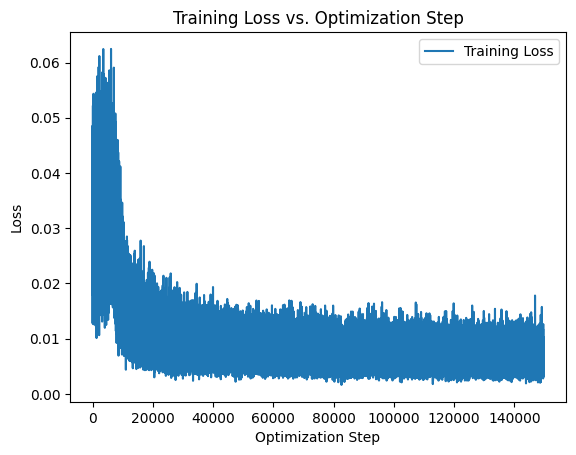

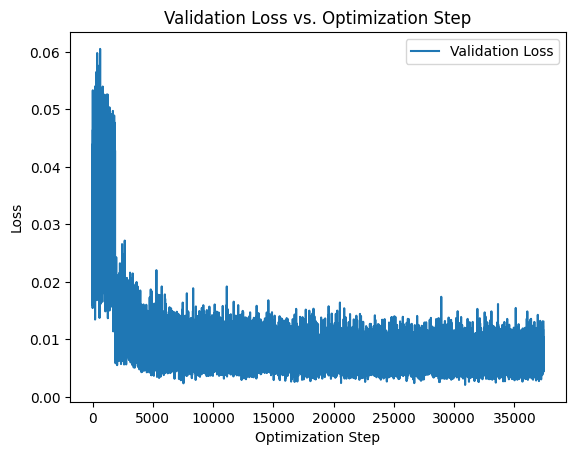

In [ ]:
import matplotlib.pyplot as plt

test_losses = [evaluate(model, test_loader, device) for model in sampled_models]

# Training losses
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.xlabel('Optimization Step')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss vs. Optimization Step')
plt.show()

# Validation losses
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Optimization Step')
plt.ylabel('Loss')
plt.legend()
plt.title('Validation Loss vs. Optimization Step')
plt.show()

####Exemple de prédiction de fitness entre une séquence `starting_seq` et une séquence `binding` tiré de l'ensemble

In [ ]:
def one_hot_encode_dna(starting_seq, binding_seq, input_size):
    sequence = starting_seq + binding_seq
    seq_len = len(sequence)
    encoding = np.zeros((seq_len, 4))
    base_to_index = {'A': 0, 'C': 1, 'G': 2, 'T': 3}
    
    for i, base in enumerate(sequence):
        encoding[i, base_to_index[base]] = 1
    
    padded_encoding = np.zeros((input_size // 4, 4))
    padded_encoding[:min(seq_len, input_size // 4)] = encoding[:min(seq_len, input_size // 4)]
    return padded_encoding.reshape(1, -1)
    
def predict_fitness(model, starting_seq, binding_seq):
    model.eval()
    input_sequence_encoded = one_hot_encode_dna(starting_seq, binding_seq, input_size)
    input_tensor = torch.tensor(input_sequence_encoded, dtype=torch.float32).to(device)
    with torch.no_grad():
        predicted_fitness = model(input_tensor).item()
    return predicted_fitness

In [ ]:
starting_seq = "GCTCGAGC"  
binding = "TCTCCAAG"  
predicted_fitness = predict_fitness(model, starting_seq, binding)
print(f"Predicted fitness for the starting sequence '{starting_seq}' and binding '{binding}': {predicted_fitness}")
print(f"Real fitness for the starting sequence '{starting_seq}' and binding '{binding}': {0.5071331381684739}")

Predicted fitness for the starting sequence 'GCTCGAGC' and binding 'TCTCCAAG': 0.5075547695159912
Real fitness for the starting sequence 'GCTCGAGC' and binding 'TCTCCAAG': 0.5071331381684739




---



#2. Modèle Transformer de type GPT-2

In [ ]:
# Imports
import pandas as pd
import numpy as np
import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from transformers import GPT2Config

In [ ]:
class SentenceDataset(Dataset):
    def __init__(self, inputs):
        self.inputs = inputs

    def __len__(self):
        return len(self.inputs["input_ids"])

    def __getitem__(self, idx):
        return {"input_ids": self.inputs["input_ids"][idx], "attention_mask": self.inputs["attention_mask"][idx]}

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
config = GPT2Config.from_pretrained('gpt2', dropout=0.1)
model_gpt2 = GPT2LMHeadModel.from_pretrained('gpt2', config=config)

dna_tokens = ['A', 'C', 'G', 'T']
num_added_tokens = tokenizer.add_tokens(dna_tokens)
model_gpt2.resize_token_embeddings(len(tokenizer))
tokenizer.pad_token = '[PAD]'  

# Load data
train_data = pd.read_csv(training_data_pth)
test_data = pd.read_csv(test_data_pth)

# Remove unnecessary columns
train_data = train_data.drop(columns=["Unnamed: 0"])
test_data = test_data.drop(columns=["Unnamed: 0"])

train_data['seq_pair'] = train_data['starting_seq'] + train_data['binding']
test_data['seq_pair'] = test_data['starting_seq'] + test_data['binding']

train_seqs = train_data['starting_seq'].values
test_seqs = test_data['starting_seq'].values

# Split into training and validation sets
X_train, X_val = train_test_split(train_seqs, test_size=0.2, random_state=42)

max_length = 16 
inputs = tokenizer(X_train.tolist(), return_tensors="pt", padding=True, truncation=True, max_length=max_length)
dataset = SentenceDataset(inputs)
train_loader = DataLoader(dataset, batch_size=128, shuffle=True)

inputs_val = tokenizer(X_val.tolist(), return_tensors="pt", padding=True, truncation=True, max_length=max_length)
dataset_val = SentenceDataset(inputs_val)
val_loader = DataLoader(dataset_val, batch_size=128, shuffle=False)

optimizer = torch.optim.Adam(model_gpt2.parameters(), lr=2e-5)
model_gpt2.to(device)
model_gpt2.train()

num_epochs = 20
patience = 3
best_val_loss = float('inf')
num_bad_epochs = 0

def evaluate(model, val_loader):
    model.eval()
    total_loss = 0
    num_batches = 0

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = input_ids.clone().detach()
            labels[labels == tokenizer.pad_token_id] = -100
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss

            total_loss += loss.item()
            num_batches += 1

    return total_loss / num_batches

for epoch in range(num_epochs):
    model_gpt2.train()

    for batch_idx, batch in enumerate(train_loader):
        optimizer.zero_grad()
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = input_ids.clone().detach()
        labels[labels == tokenizer.pad_token_id] = -100
        outputs = model_gpt2(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        if batch_idx % 500 == 0:
          print("Epoch {} Batch {} Train Loss {:.4f}".format(epoch + 1, batch_idx + 1, loss.item()))

    val_loss = evaluate(model_gpt2, val_loader)
    print("Epoch {} Validation Loss {:.4f}".format(epoch + 1, val_loss))

    # Check if the validation loss has improved
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        num_bad_epochs = 0
    else:
        num_bad_epochs += 1

    if num_bad_epochs >= patience:
        print(f"Validation loss didn't improve for {patience} epochs")
        break

Epoch 1 Batch 1 Train Loss 0.2752
Epoch 1 Batch 501 Train Loss 0.1466
Epoch 1 Batch 1001 Train Loss 0.1389
Epoch 1 Batch 1501 Train Loss 0.1106
Epoch 1 Validation Loss 0.1363
Epoch 2 Batch 1 Train Loss 0.1137
Epoch 2 Batch 501 Train Loss 0.1483
Epoch 2 Batch 1001 Train Loss 0.1593
Epoch 2 Batch 1501 Train Loss 0.1325
Epoch 2 Validation Loss 0.1357
Epoch 3 Batch 1 Train Loss 0.1489
Epoch 3 Batch 501 Train Loss 0.1249
Epoch 3 Batch 1001 Train Loss 0.1480
Epoch 3 Batch 1501 Train Loss 0.1210
Epoch 3 Validation Loss 0.1356
Epoch 4 Batch 1 Train Loss 0.1192
Epoch 4 Batch 501 Train Loss 0.1192
Epoch 4 Batch 1001 Train Loss 0.1272
Epoch 4 Batch 1501 Train Loss 0.1455
Epoch 4 Validation Loss 0.1353
Epoch 5 Batch 1 Train Loss 0.1415
Epoch 5 Batch 501 Train Loss 0.1495
Epoch 5 Batch 1001 Train Loss 0.1319
Epoch 5 Batch 1501 Train Loss 0.1309
Epoch 5 Validation Loss 0.1353
Epoch 6 Batch 1 Train Loss 0.1367
Epoch 6 Batch 501 Train Loss 0.1499
Epoch 6 Batch 1001 Train Loss 0.1332
Epoch 6 Batch 1501

In [ ]:
model_gpt2.save_pretrained('gpt2')
tokenizer.save_pretrained('gpt2')

model_gpt2 = GPT2LMHeadModel.from_pretrained('gpt2')
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

####Évaluation du modèle génératif GPT-2 sur l'ensemble test `test_loader`


In [ ]:
test_inputs = tokenizer(test_seqs.tolist(), return_tensors="pt", padding=True, truncation=True, max_length=max_length)

test_dataset = SentenceDataset(test_inputs)
test_loader = DataLoader(test_dataset, batch_size=128)

model_gpt2.to(device)
model_gpt2.eval()

total_loss = 0
num_batches = 0

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = input_ids.clone().detach()
        labels[labels == tokenizer.pad_token_id] = -100
        outputs = model_gpt2(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()
        num_batches += 1

average_test_loss = total_loss / num_batches
print("GPT-2 model loss on test data: {:.4f}".format(average_test_loss))

GPT-2 model loss on test data: 0.1429


####Exemple de génération de séquences à partir d'une `start_sequence` tiré de l'ensemble test 

In [ ]:
start_seq = 'GCTCGAGC'
input_ids = tokenizer.encode(start_seq, return_tensors='pt').to(device)  
attention_mask = input_ids.ne(tokenizer.pad_token_id).float().to(device) 

generated_sequence = model_gpt2.generate(
    input_ids=input_ids,
    attention_mask=attention_mask,
    do_sample=True,
    top_p=0.95,
    num_return_sequences=10
)

for sequence in generated_sequence:
    print(tokenizer.decode(sequence))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1313: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


GCTCGAGCGCGTTCTGAGCTGAGTATAGGAGT
GCTCGAGCAGGAGAGTACGAGTACAGTATGCT
GCTCGAGCACCTGCTGATGACGAGGTTTCTG
GCTCGAGCATTTGTTGTTTACGCTGACGCTG
GCTCGAGCACAGTATGCTTATGATGCTGATG
GCTCGAGCAGCTAGTTTACGAGTACGATAGGAG
GCTCGAGCAGTTTCTTCTGTTGAGTATATGAT
GCTCGAGCAGTATGCTGTTTTTATGTTTCTAT
GCTCGAGCATAGTACGAGTATGTTGATGCTG
GCTCGAGCAGTCTATGTTGAGGAGTCTGAGT




---



#3. Échantillonnage par rejet

In [ ]:
# Génère une séquence de candidats en utilisant le modèle génératif GPT-2
def generate_candidate_sequence(prompt, model_gpt, tokenizer, max_length):
    input_ids = tokenizer.encode(prompt, return_tensors='pt').to(device)
    attention_mask = (input_ids != tokenizer.pad_token_id).long().to(device)
    generated_output = model_gpt.generate(input_ids, max_length=max_length, do_sample=True, num_return_sequences=10, attention_mask=attention_mask, pad_token_id=tokenizer.eos_token_id)
    candidate_sequence = tokenizer.decode(generated_output[0], skip_special_tokens=True)
    return candidate_sequence

# Prédit la fitness d'une séquence en utilisant le modèle multi-SWAG
def predict_fitness_swag_models(swag_models, starting_seq, binding_seq):
    input_sequence_encoded = one_hot_encode_dna(starting_seq, binding_seq, input_size)
    input_tensor = torch.tensor(input_sequence_encoded, dtype=torch.float32).to(device)

    avg_prediction = 0
    with torch.no_grad():
        for model in swag_models:
            model = swag.sample()
            model.eval()
            prediction = model(input_tensor).item()
            avg_prediction += prediction
    
    avg_prediction /= len(swag_models)
    return avg_prediction

In [ ]:
def rejection_sampling(prompt, model_gpt, tokenizer, swag_models, max_length, threshold=0.6, max_attempts=1000):
    for _ in range(max_attempts):
        candidate_sequence = generate_candidate_sequence(prompt, model_gpt, tokenizer, max_length)
        starting_seq = candidate_sequence[:len(prompt)]
        binding_seq = candidate_sequence[len(prompt):]
        
        # Prédire la fitness de la séquence candidate à l'aide du modèle multi-SWAG
        predicted_fitness = predict_fitness_swag_models(swag_models, starting_seq, binding_seq)
        
        # Accepre ou rejette la séquence candidate selon le threshold
        if predicted_fitness >= threshold:
            return candidate_sequence

    # Si aucune séquence n'est supérieur au seuil threshold, on renvoit la dernière séquence
    return candidate_sequence

####Exemple d'utilisation de l'apprentissage par rejet pour affiner des séquences générées par notre modèle génératif GPT-2 à l'aide du modèle de substitution mutli-SWAG

In [ ]:
starting_seq = "CCTTCTTT"
refined_sequence = rejection_sampling(starting_seq, model_gpt2, tokenizer, swag_models, max_length=16)
print(f"Refined sequence: {refined_sequence}")

Refined sequence: CCTTCTTTTTATATTTGTTTCTGTTGCT


####Visualisation pour le même exemple `starting_seq = "CCTTCTTT"`




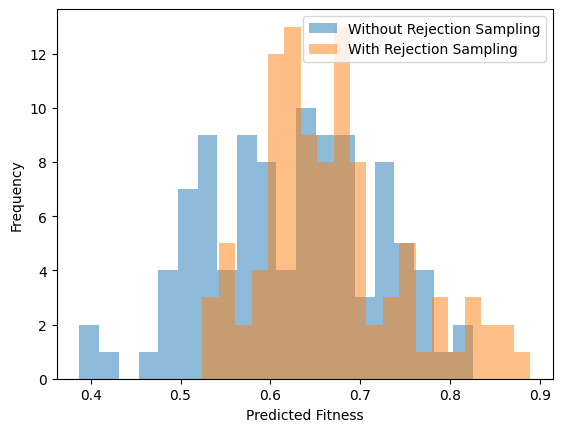

In [ ]:
import matplotlib.pyplot as plt

# Génération des séquences à l'aide du modèle GPT-2 sans échantillonnage par rejet
def generate_sequences_without_sampling(prompt, model_gpt, tokenizer, num_sequences, max_length):
    input_ids = tokenizer.encode(prompt, return_tensors='pt').to(device)
    attention_mask = (input_ids != tokenizer.pad_token_id).long().to(device)
    generated_output = model_gpt.generate(input_ids, max_length=max_length, do_sample=True, num_return_sequences=num_sequences, attention_mask=attention_mask, pad_token_id=tokenizer.eos_token_id)
    sequences = [tokenizer.decode(seq, skip_special_tokens=True) for seq in generated_output]
    return sequences

starting_seq = "CCTTCTTT"
num_sequences = 100

# Sans échantillonnage par rejet
sequences_without_sampling = generate_sequences_without_sampling(starting_seq, model_gpt2, tokenizer, num_sequences, 16)

# Avec échantillonnage de rejet
sequences_with_sampling = [rejection_sampling(starting_seq, model_gpt2, tokenizer, swag_models, max_length=16, max_attempts=100) for _ in range(num_sequences)]

# Valeurs Fitness 
fitness_without_sampling = [predict_fitness_swag_models(swag_models, seq[:len(starting_seq)], seq[len(starting_seq):]) for seq in sequences_without_sampling]
fitness_with_sampling = [predict_fitness_swag_models(swag_models, seq[:len(starting_seq)], seq[len(starting_seq):]) for seq in sequences_with_sampling]

plt.hist(fitness_without_sampling, bins=20, alpha=0.5, label="Without Rejection Sampling")
plt.hist(fitness_with_sampling, bins=20, alpha=0.5, label="With Rejection Sampling")
plt.xlabel("Predicted Fitness")
plt.ylabel("Frequency")
plt.legend()
plt.show()

#### Comparaison du générateur sans affinage et par échantillonnage par rejet sur 100 séquences `starting_seq` tirés de l'ensemble de test 

In [ ]:
def compute_fitness_values(starting_seqs, model_gpt2, tokenizer, swag_models):
    fitness_without_sampling = []
    fitness_with_sampling = []

    for starting_seq in starting_seqs:
        # Sans échantillonnage par rejet
        fitness_wo = predict_fitness_swag_models(swag_models, starting_seq, "")
        fitness_without_sampling.append(fitness_wo)

        # Avec échantillonnage par rejet
        refined_seq_sampling = rejection_sampling(starting_seq, model_gpt2, tokenizer, swag_models, max_length=16)
        binding_seq_sampling = refined_seq_sampling[len(starting_seq):]
        fitness_sampling = predict_fitness_swag_models(swag_models, starting_seq, binding_seq_sampling)
        fitness_with_sampling.append(fitness_sampling)
        
    return fitness_without_sampling, fitness_with_sampling

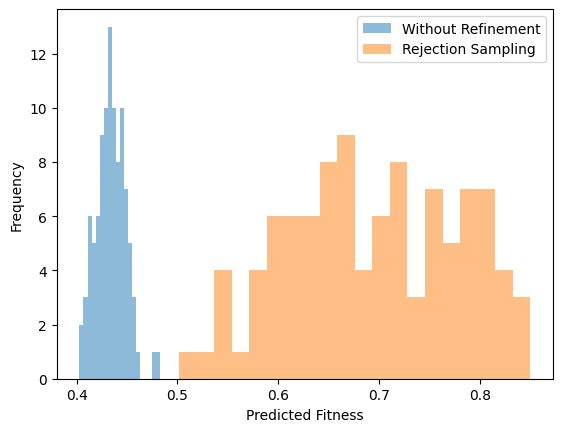

In [ ]:
test_starting_seqs = test_data["starting_seq"].values[:100] 
fitness_without_sampling, fitness_with_sampling = compute_fitness_values(test_starting_seqs, model_gpt2, tokenizer, swag_models)


plt.hist(fitness_without_sampling, bins=20, alpha=0.5, label="Without Refinement")
plt.hist(fitness_with_sampling, bins=20, alpha=0.5, label="Rejection Sampling")
plt.xlabel("Predicted Fitness")
plt.ylabel("Frequency")
plt.legend()
plt.show()

Il est possible d'observer que l'application de l'échantillonnage par rejet aux séquences générées avec le modèle transformateur GPT-2 entraîne des valeurs de fitness prédites plus élevées par rapport à celles qui n'utilisent pas cette méthode. Comme le montre l'étape 1, les prédictions présentent une erreur de perte moyenne de 0.01311 sur l'ensemble test fourni.



---



#4. Méthode d’échantillonnage MCMC de type Metropolis-Hasting

In [ ]:
import numpy as np

def mutate_sequence(sequence, mutation_rate=0.1):
    mutated_sequence = ""
    for base in sequence:
        if np.random.rand() < mutation_rate:
            mutated_sequence += np.random.choice(dna_tokens) 
        else:
            mutated_sequence += base
    return mutated_sequence

def metropolis_hastings(prompt, model_gpt, tokenizer, swag_models, max_length, num_samples, mutation_rate=0.1):
    current_sequence = generate_candidate_sequence(prompt, model_gpt, tokenizer, max_length)
    current_fitness = predict_fitness_swag_models(swag_models, current_sequence[:len(prompt)], current_sequence[len(prompt):])
    
    samples = [current_sequence]
    fitness_values = [current_fitness]
    
    for _ in range(num_samples - 1):
        # Génère une séquence candidate en muttant la séquence courante
        candidate_sequence = mutate_sequence(current_sequence, mutation_rate=mutation_rate)
        candidate_fitness = predict_fitness_swag_models(swag_models, candidate_sequence[:len(prompt)], candidate_sequence[len(prompt):])
        
        acceptance_probability = min(1, np.exp(candidate_fitness - current_fitness))
        
        # Accepte ou rejette la séquence candidate selon la prob d'aecceptation
        if np.random.rand() < acceptance_probability:
            current_sequence = candidate_sequence
            current_fitness = candidate_fitness
        
        samples.append(current_sequence)
        fitness_values.append(current_fitness)
    
    return samples, fitness_values

#### Comparaison du générateur sans affinage, avec échantillonnage par rejet et avec une méthode d’échantillonnage MCMC de type Metropolis-Hasting sur 100 séquences `starting_seq` tirés de l'ensemble de test 

In [ ]:
def compute_fitness_mh(starting_seqs, model_gpt2, tokenizer, swag_models):
    fitness_mh = []
    for starting_seq in starting_seqs:
        # Metropolis-Hastings
        samples, fitness_values = metropolis_hastings(starting_seq, model_gpt2, tokenizer, swag_models, max_length=16, num_samples=num_sequences)
        
        # Choisir le fitness le plus élevé
        best_index = np.argmax(fitness_values)
        
        binding_seq_mh = samples[best_index][len(starting_seq):]
        fitness_mh_value = predict_fitness_swag_models(swag_models, starting_seq, binding_seq_mh)
        fitness_mh.append(fitness_mh_value)
        
    return fitness_mh

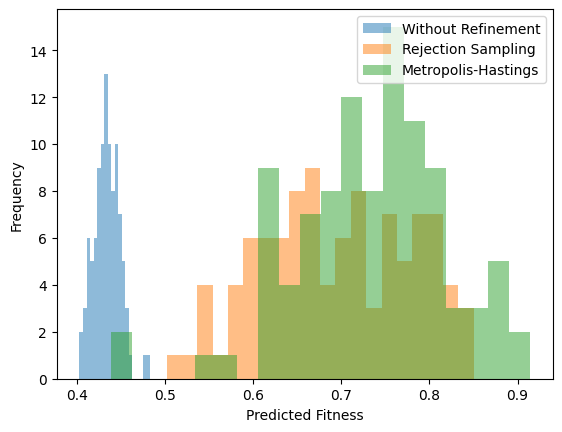

In [ ]:
fitness_mh = compute_fitness_mh(test_starting_seqs, model_gpt2, tokenizer, swag_models)

plt.hist(fitness_without_sampling, bins=20, alpha=0.5, label="Without Refinement")
plt.hist(fitness_with_sampling, bins=20, alpha=0.5, label="Rejection Sampling")
plt.hist(fitness_mh, bins=20, alpha=0.5, label="Metropolis-Hastings")
plt.xlabel("Predicted Fitness")
plt.ylabel("Frequency")
plt.legend()
plt.show()

Il est possible d'observer que l'application de la méthode Metropolis-Hastings aux séquences générées avec le modèle transformateur GPT-2 entraîne des valeurs de fitness prédites plus élevées par rapport à celles qui utilisent l'échantillonnage par rejet.

De plus, la méthode d'échantillonnage par rejet peut être inefficace, car elle nécessite de générer un grand nombre d'échantillons aléatoires avant d'obtenir un échantillon qui satisfait aux critères d'acceptation. En revanche, la méthode de Metropolis-Hastings peut être plus efficace, car elle utilise des mécanismes de rééchantillonnage qui permettent d'explorer l'espace de recherche de manière plus efficace et d'obtenir des échantillons de manière plus ciblée. Donc, Metropolis-Hastings pourrait trouver des séquences optimales plus rapidement que la méthode d'échantillonnage par rejet.



---

